In [6]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from utils.plot_utils import regression_plot_with_uncertainty, regression_plot_with_scores
from utils.Prediction_bands import(split_conformal_bands,
                                   weighted_conformal_prediction
                                   
)
from concurrent.futures import ThreadPoolExecutor

from scipy.stats import multivariate_normal, norm


In [30]:
def __start__pred__(X, Y, alpha, rho, train_lag, rho_ls, ntrial, N):
    methods = ["CP+LS", "NexCP+LS", "NexCP+WLS"]

    # Initialize prediction intervals
    PI_split_CP = np.zeros((len(methods), ntrial, N, 2))
    PI_split_CP[:, :, :train_lag, 0] = -np.inf
    PI_split_CP[:, :, :train_lag, 1] = np.inf

    # Main loop
    for trial in tqdm(np.arange(ntrial)):
        for pred_idx in range(train_lag, N):
            for method_idx, method in enumerate(methods):
                if method == "CP+LS":
                    weights = np.ones(pred_idx+1)
                    tags = np.ones(pred_idx)
                else:
                    weights = rho ** np.arange(pred_idx, 0, -1)
                    weights = np.r_[weights, 1]  # Fix append

                if method == "NexCP+WLS":
                    tags = rho_ls ** np.arange(pred_idx, -1, -1)
                else:
                    tags = np.ones(pred_idx + 1)  # Default tags for other methods

                idx_odd = np.arange(1, int(np.ceil(pred_idx / 2) * 2), 2)
                idx_even = np.arange(0, int(np.floor(pred_idx / 2) * 2), 2)

                predictor = LinearRegression()
                predictor.fit(X[idx_odd], Y[idx_odd], tags[idx_odd])  # Correct indexing

                mean_predictions, prediction_bands, quantile = weighted_split_conformal_prediction(
                    predictor,
                    X[idx_even],
                    Y[idx_even],
                    X[pred_idx][np.newaxis, :],  # Correct indexing
                    weights[idx_even],
                    alpha
                )

                PI_split_CP[method_idx, trial, pred_idx, :] = prediction_bands
    
    print("Finished processing.")
    return PI_split_CP

# SIMULATION STUDY
$$\textbf{Setting 1: i.i.d. data} X_i \sim \mathcal{N}(0, \textbf{I}_{4}) \text{  and  } Y_i \sim X_i^T\beta + \mathcal{N}(0, 1) $$

We first let $\beta = (2, 1, 0, 0)$


Generate data


In [27]:
np.random.seed(12345)
N = 2000
beta = [2, 1, 0, 0]
alpha = 0.1
ntrial = 200
train_lag = 100
methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS', "gaussian"]

rho = rho_ls = 0.99
# Data generation
X = np.random.normal(size = (ntrial, N, 4))
Y = np.zeros((ntrial, N))

noise = np.random.normal(size =(ntrial, N))

for i in np.arange(N):
    Y[:, i] = np.dot(X[:, i], beta) + noise[:, i]

In [28]:
PI_split_CP = np.zeros((len(methods),ntrial,N,2))
PI_split_CP[:, :, :train_lag, 0] = -np.inf
PI_split_CP[:, :, :train_lag, 1] = np.inf
all_weights = np.empty((len(methods), ntrial, N), dtype=object)

In [79]:
def run_trial(itrial):
    for pred_idx in np.arange(train_lag, N):
        # we predict the point at pred_idx (n+1) starting at pred_idx=train_lag (101-th datapoint)

        for method_idx, method in enumerate(methods):
            # calibration weights for non-exchangeable conformal prediction (nexCP)
            if method in ['nexCP+LS', 'nexCP+WLS']:
                # weights at 1, ..., n (notice: in Python arrays this becomes 0, ..., n-1)
                weights = rho**(np.arange(pred_idx, 0, -1))
                # weight n+1 should always be 1
                weights = np.r_[weights, 1]
        
            elif method == "gaussian":
                # h = 1.06 * np.std(Y[itrial, :pred_idx], ddof=1) * (pred_idx + 1)**(-1/5)
                h = 1.06 * np.std(X[itrial, :pred_idx], ddof=1) * (pred_idx + 1)**(-1/5)
                # h = h[0]  
                # h = 1.5

                
                X_tilde = multivariate_normal.rvs(mean=X[itrial - 1, pred_idx], cov=np.diag(np.ones(4)) * h**2)
                weights = np.exp(-0.5 * np.sum(X[itrial, :pred_idx] - X_tilde, axis=1) / h**2)
                weights = np.r_[weights, 1]
                
            else:
                weights = np.ones(pred_idx + 1)
            
            # weights for weighted linear regression (WLS)
            if method == 'nexCP+WLS':
                # tags 1, ..., n+1
                tags = rho_LS**(np.arange(pred_idx, -1, -1))
                
            elif method == 'gaussian':
                tags = weights
            else:
                tags = np.ones(pred_idx + 1)
            
            # odd data points for training, even ones for calibration
            inds_odd = np.arange(1, int(np.ceil(pred_idx / 2) * 2 - 1), 2)  # excludes pred_idx
            inds_even = np.arange(2, int(np.floor(pred_idx / 2) * 2), 2)  # excludes pred_idx

            # Ensure X_train and Y_train are reshaped correctly
            X_train = X[itrial, inds_odd]
            Y_train = Y[itrial, inds_odd]

            if X_train.shape[0] != Y_train.shape[0] or X_train.shape[0] != tags[inds_odd].shape[0]:
                print(f"Shape mismatch at itrial: {itrial}, pred_idx: {pred_idx}, method: {method}")
                print(f"X_train shape: {X_train.shape}")
                print(f"Y_train shape: {Y_train.shape}")
                print(f"tags[inds_odd] shape: {tags[inds_odd].shape}")
                continue  # Skip to the next iteration if shapes do not match

            predictor = LinearRegression()
            if method == 'CP+LS':
                predictor.fit(X_train, Y_train)
            else:     
                predictor.fit(X_train, Y_train, sample_weight=tags[inds_odd])

            _, prediction_bands, _, _ = weighted_conformal_prediction(
                predictor,  # the trained weighted linear regression model
                X[itrial, inds_even],  # calibration inputs
                Y[itrial, inds_even],  # calibration targets
                X[itrial, pred_idx][np.newaxis, :],  # test point to predict
                weights[inds_even],  # calibration score weights
                alpha  # target miscoverage rate
            )
            PI_split_CP[method_idx, itrial, pred_idx, :] = prediction_bands
            
            if pred_idx == N - 1:
                weights_normalised = weights / np.sum(weights)
                all_weights[method_idx, itrial, :len(weights)] = weights_normalised
                



In [80]:
for i in tqdm(np.arange(ntrial)):
    run_trial(i)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [13:25<00:00,  4.03s/it]


In [81]:
X.shape

(200, 2000, 4)

In [82]:
PI_split_CP.shape

(4, 200, 2000, 2)

In [83]:
methods = ["CP+LS", "NexCP+LS", "NexCP+WLS", "gaussian"]

In [84]:
coverage = np.zeros((len(methods), N - train_lag))
pi_width = np.zeros((len(methods), N - train_lag))

# compute coverage for each time step and trial
for method_idx, method in enumerate(methods):
    lower_bound = PI_split_CP[method_idx, :, train_lag:, 0]
    upper_bound = PI_split_CP[method_idx, :, train_lag:, 1]

    # Ensure that lower_bound, upper_bound, and Y[:, train_lag:] have the same shape
    assert lower_bound.shape == upper_bound.shape == Y[:, train_lag:].shape, \
        f"Shape mismatch: {lower_bound.shape}, {upper_bound.shape}, {Y[:, train_lag:].shape}"

    # coverage is averaged over ntrials
    coverage[method_idx] = np.mean((lower_bound <= Y[:, train_lag:]) & (upper_bound >= Y[:, train_lag:]), axis=0)
    pi_width[method_idx] = np.mean(upper_bound - lower_bound, axis=0)


In [85]:
lower_bound_gauss = PI_split_CP[3, :, train_lag:, 0]
upper_bound_gauss = PI_split_CP[3, :, train_lag:, 1]

upper_bound_gauss[0] - lower_bound_gauss[0]

array([4.13082643, 4.07011695, 4.07011695, ..., 3.30093254, 3.30093254,
       3.30112421])

In [86]:
Y[:, train_lag:].shape

(200, 1900)

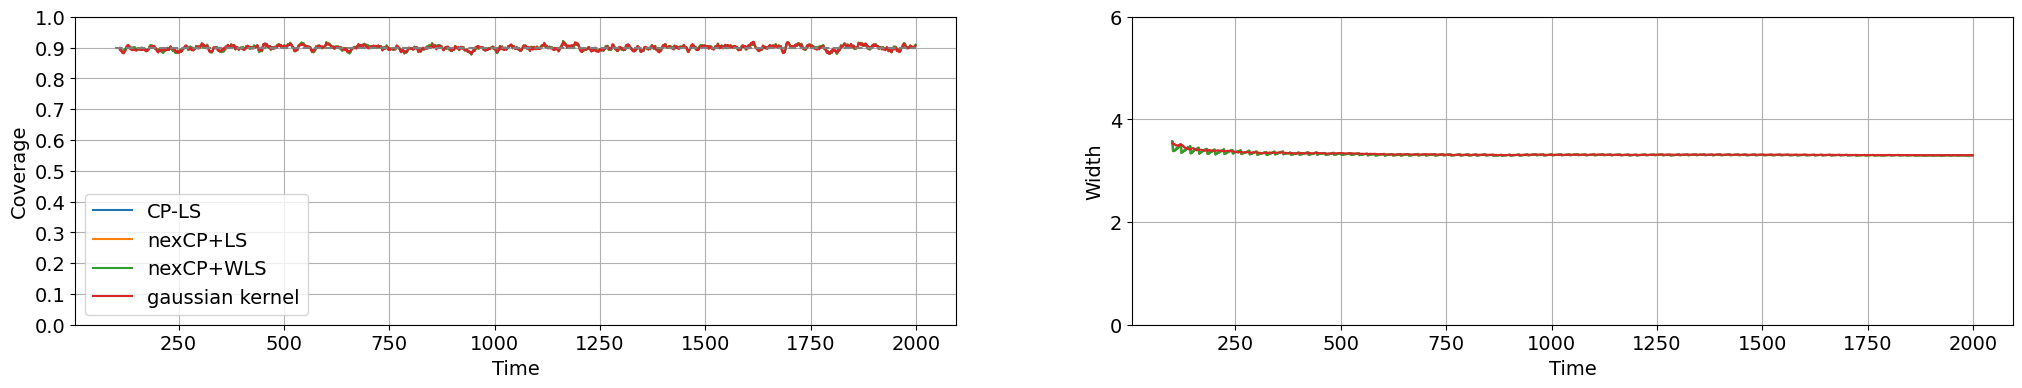

In [89]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag, N), pi_width[method_idx])

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS', "gaussian kernel"])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 2, 4, 6])
ax[1].set_xlabel('Time')
ax[1].grid(True)

plt.savefig('simulation_1.png')
plt.show()

In [88]:
for method_idx, method in enumerate(methods):
    print(f'{method}')
    print('-'*10)
    print(f'Avg. coverage: {np.mean(coverage[method_idx]):.3f}')
    print(f'Avg. interval width: {np.mean(pi_width[method_idx]):.2f}')
    print()

CP+LS
----------
Avg. coverage: 0.899
Avg. interval width: 3.32

NexCP+LS
----------
Avg. coverage: 0.899
Avg. interval width: 3.32

NexCP+WLS
----------
Avg. coverage: 0.899
Avg. interval width: 3.32

gaussian
----------
Avg. coverage: 0.899
Avg. interval width: 3.32



In [46]:
import pandas as pd
data = {'Method': methods,
    'Avg. Coverage': [np.mean(coverage[method_idx]) for method_idx in range(len(methods))],
    'Avg. Interval Width': [np.mean(pi_width[method_idx]) for method_idx in range(len(methods))]}
df = pd.DataFrame(data)

df.head()


,Method,Avg. Coverage,Avg. Interval Width
0,CP+LS,0.901905,3.346911
1,NexCP+LS,0.915005,3.512541
2,NexCP+WLS,0.914595,3.576508


In [53]:
!pip install pyperclip

In [54]:
import pyperclip
latex_table = df.to_latex(index=False, float_format="%.3f", column_format="lcc")
pyperclip.copy(latex_table)
print("LaTeX table copied to clipboard.")


LaTeX table copied to clipboard.
